In [171]:
import pandas as pd
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import os
import boto3
import time
import re
import json
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex
from matplotlib.lines import Line2D
from google.oauth2 import service_account
from googleapiclient.discovery import build
import seaborn as sns
STAGING_BUCKET = os.environ['STAGING_BUCKET']
ATHENA_CURSOR = connect(s3_staging_dir=STAGING_BUCKET,
                 region_name="us-west-2",
                 cursor_class=PandasCursor).cursor()

In [173]:
sm = boto3.client("secretsmanager")
secret_json = sm.get_secret_value(SecretId="SheetsAndDriveAPIServiceAcctCredentials")[
    "SecretString"
]

secret_data = json.loads(secret_json)
scopes = ["https://www.googleapis.com/auth/spreadsheets"]

creds = service_account.Credentials.from_service_account_info(
    secret_data, scopes=scopes
)
_r = "data-for-jake!A3:A103"
service = build("sheets", "v4", credentials=creds)
sheets = service.spreadsheets()
SHEET_ID = '1DAq1n7oEv4AJ-AjTt0c1EP0riksxbhMZGZKMi4ilR5I'

In [178]:
df = (
    pd.DataFrame(
        sheets.values()
        .get(spreadsheetId=SHEET_ID, range=_r, majorDimension='ROWS')
        .execute()['values'])
)
df.rename(columns={0: 'aims'}, inplace=True)
df.head()

,aims
0,AIM020846
1,AIM047480
2,AIM034391
3,AIM047262
4,AIM018509


In [2]:
q = f"""
    SELECT * FROM "genomics"."comparesketch_alltoall" 
    WHERE jobid = '7e059d3c-882c-4871-84d3-440613df6207'
    """
dist_matrix = ATHENA_CURSOR.execute(q).as_pandas()

In [4]:
def extract_aim(identifier):
    return int(re.search('AIM(\d+)', identifier).group(1))

In [6]:
dist_matrix['aim'] = dist_matrix['query'].apply(extract_aim)
dist_matrix['target'] = dist_matrix['subject'].apply(extract_aim)

In [161]:
df = dist_matrix.sort_values(by='kid', ascending=True)

In [163]:
df2 = (
    df[['aim', 'target', 'kid']]
    .set_index(['aim', 'target'])
    .kid.unstack()
    .rename_axis([None], axis=1)
    .fillna(0.0)
    .round(2)
)

In [164]:
df2.head()

,74130,74665,74670,74673,74674,74680,74681,74684,74702,74721,74725,74728,74730,74734,90742,90748
aim,,,,,,,,,,,,,,,,
74130,100.00,58.15,59.53,59.49,58.04,62.25,0.0,62.24,59.27,62.34,0.0,0.0,0.0,0.0,0.0,0.0
74665,58.15,100.00,92.75,94.51,91.99,85.86,0.0,85.92,88.73,86.47,0.0,0.0,0.0,0.0,0.0,0.0
74670,59.53,92.75,100.00,96.38,94.91,89.31,0.0,89.42,90.85,87.59,0.0,0.0,0.0,0.0,0.0,0.0
74673,59.49,94.51,96.38,100.00,93.47,89.26,0.0,89.33,89.47,87.52,0.0,0.0,0.0,0.0,0.0,0.0
74674,58.04,91.99,94.91,93.47,100.00,87.27,0.0,87.36,88.41,85.66,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:ylabel='aim'>

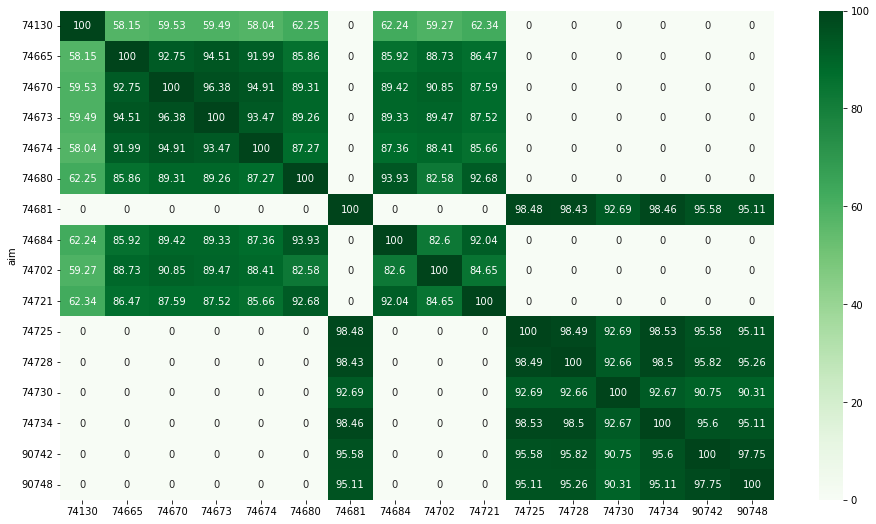

In [167]:
plt.figure(figsize=(16,9))
sns.heatmap(df2, annot=True, fmt='g', cmap = sns.color_palette("Greens", as_cmap=True))